In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob
from pycorn import pc_uni6
from scipy.stats import gaussian_kde

cmap_tab = plt.get_cmap('tab10')
cmap_seq = plt.get_cmap('viridis')
cmap_blue = plt.get_cmap('Blues')

In [2]:
def parse_file(file):
    # from Ryan Kibler
    
    #loads the zipped files and parses the xml to collect the data. Returns a pandas dataframe
    fdata = pc_uni6(file)
    fdata.load()
    fdata.xml_parse()
    fdata.clean_up()

    #print(fdata.keys())
    #print(fdata['UV 1_280'])

    return pd.DataFrame().from_dict({key:fdata[key]['data'] for key in fdata.keys()},orient='index').transpose()

def eqm_binding(conc, K_D, high):
    return high*conc/(conc + K_D)

def eqm_binding_complex(conc_protein,conc_peptide,low,high,K_D):
    KDsum = conc_protein + conc_peptide + K_D
    f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)
    return low + f_bound*(high-low)

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.498'}
added - orig data
added - orig data
added - orig data


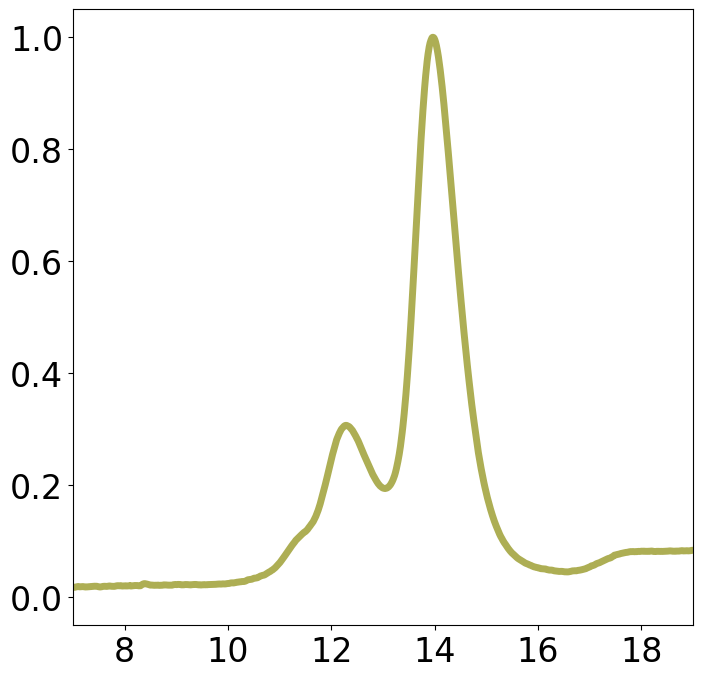

In [3]:
files = ['20250815_Laura_FP_SEC/A02_CSM8_monomer.zip',
         '20250815_Laura_FP_SEC/A02_SMART_monomer.zip']
colors = ['#ADAE54','#48327F','red']
names = ['CSM8','CSM8 L11']

plt.figure(figsize=[8,8])

for f,file in enumerate(files[:1]):
    A02 = parse_file(file)
    A02_uv = np.array(list(A02['UV 1_280']))
    
    plt.plot(A02_uv[:,0],A02_uv[:,1]/max(A02_uv[:,1]),linewidth=5,color=colors[f],label=names[f])
plt.xlim([7,19])
# plt.ylim([-10,670])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.legend(loc=[0.025,0.8],fontsize=24)

plt.savefig('A02_CSM8_rerun_SEC.png',dpi=300,bbox_inches='tight')

0 [  113.72629668   416.807859   16090.63666854]


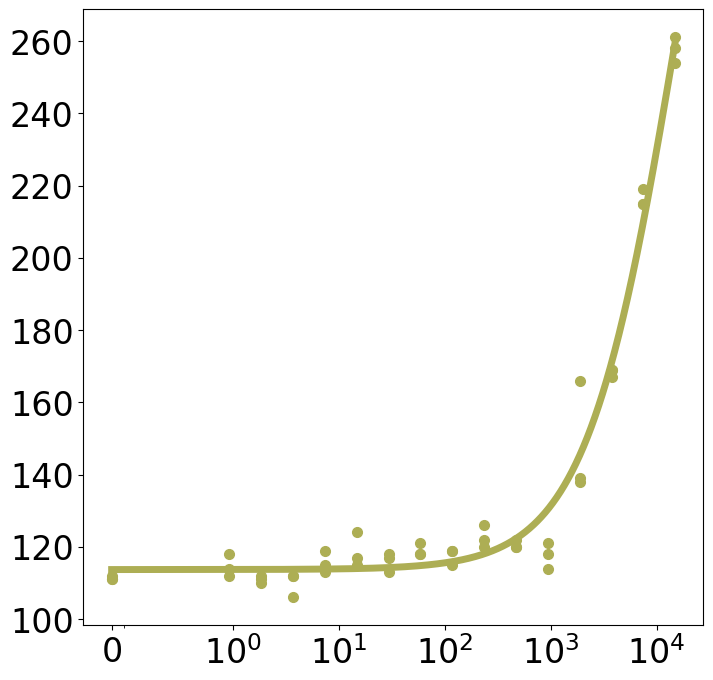

In [4]:
concs = [15000*(1/2)**i for i in range(15)] + [0]

plt.figure(figsize=[8,8])

files = ['20250815_Laura_FP_SEC/20250815_A02_CSM8_polarization.csv',
         '20250815_Laura_FP_SEC/20250815_A02_SMART_polarization.csv']
colors = ['#ADAE54','#48327F']
names = ['CSM8','CSM8-L11']
for i in range(1):

    data = pd.read_csv(files[i],index_col=0)
    data = np.concatenate([data.loc['A':'C',:].values,data.loc['D':'F',:'4'].values],axis=1).T
    
    params,_ = curve_fit(lambda x,a,b,c: eqm_binding_complex(x,10,a,b,c),
                         np.tile(concs,[3,1]).T.flatten(),data.flatten(),p0=[80,250,concs[8]])
    
    x_fit = np.concatenate([[0],
                        np.logspace(np.log10(0.5*concs[-2]),np.log10(concs[0]),1000)],axis=0)
    y_fit = eqm_binding_complex(x_fit,10,*params)
    plt.plot(x_fit,y_fit,'-',linewidth=5,color=colors[i],label=names[i])
    plt.plot(concs,data,'o',markersize=7,color=colors[i])

    print(i,params)

plt.xscale('symlog',linthresh=concs[-2])
# plt.legend(loc=[0.025,0.8],fontsize=24)
plt.yticks(fontsize=24)
plt.xticks([0,1,10,100,1000,1e4],fontsize=24)
plt.savefig(f'A02_CSM8_AF488-NYESO_binding.png',dpi=300,bbox_inches='tight')

In [5]:
def convert_from_commas(df):
    for col in df.columns:
        df[col] = df[col].astype(str).map(lambda x: float(x.replace(',','.')))
    return df

9V [1.14719113e+01 3.57868039e+08] [3.38839077e-01 3.31879628e+06]
9C [3.65181059e+01 3.03968297e+08] [5.95802932e-01 2.16286823e+06]


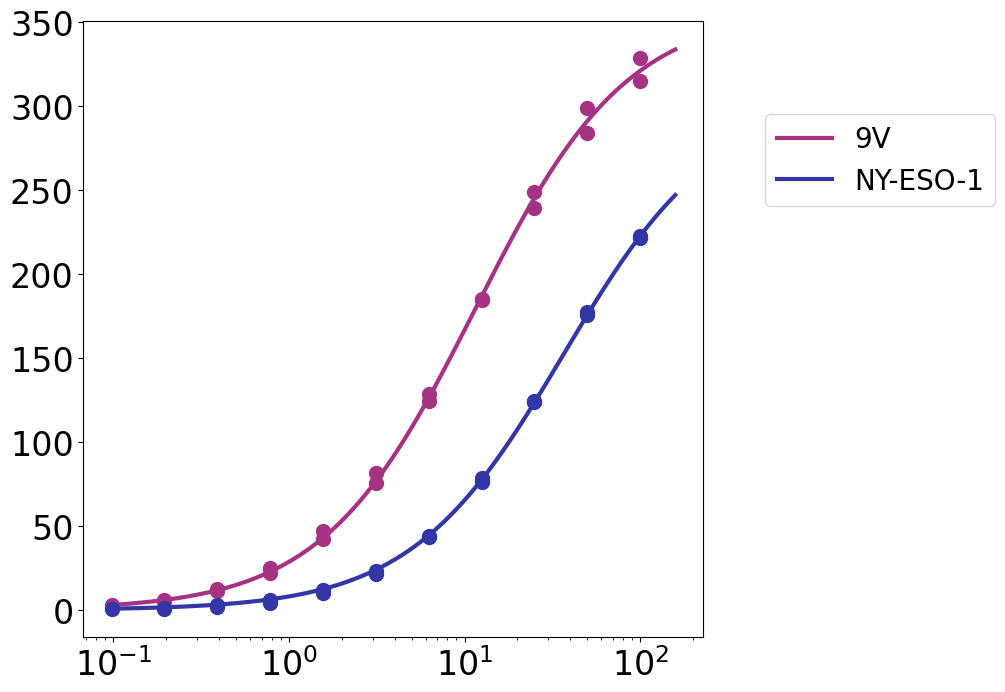

In [9]:
plt.figure(figsize=[8,8])
x_scale = 1e6
colors = ['#A63283','#3236A6']
label_convert = {
    '9V':'9V',
    '9C':'NY-ESO-1'
}

for i,pep in enumerate(['9V', '9C']):

    data_eq = []
    for rep in ['-1','-2']:
        rep_df = pd.read_csv(glob(f'20250928_CSM8_A02_SPR_refolded/rSMARTA2 {pep}{rep} kd*.txt')[0],sep='\t')
        rep_df = convert_from_commas(rep_df)
        rep_df = rep_df[~np.isnan(rep_df['X'])]
        data_eq.append(rep_df)
    data_eq = pd.concat(data_eq,axis=0).reset_index()
    
    params,cov = curve_fit(eqm_binding,data_eq["X"],data_eq["Y"],p0=[3e-5,300],bounds=[0,np.inf])
    
    x_fit = np.logspace(-7,-3.8,1000)
    y_fit = eqm_binding(x_fit,*params)
    
    print(pep, params*1e6, np.sqrt(cov)[[0,1],[0,1]]*1e6)
    
    plt.semilogx(data_eq['X']*x_scale,data_eq['Y'],'o',color=colors[i], markersize=10)
    plt.semilogx(x_fit*x_scale,y_fit,'-',color=colors[i],linewidth=3,label=label_convert[pep])

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc=[1.1,0.7],fontsize=20)
plt.savefig(f'NYESO_variant_TCR_binding_eqm.png',dpi=300,bbox_inches='tight')

# yeast display data

In [7]:
base_dir = '20250806_Tina_A02_yeast_display/single_cells/'
data = pd.read_csv(f'{base_dir}export_A02 TAX_hit6_2_Single Cells.csv')
data

,FSC-A,FSC-H,SSC-A,SSC-H,FITC_HA-A,FITC_HA-H,PE-A,PE-H,PerCP-A,PerCP-H,APC_A6c134tet-A,APC_A6c134tet-H,Time
0,1762140.0,1812550.0,83106,106212,24964,22952,2727,3061,934,1304,10052,9867,13.7
1,1923000.0,1983360.0,87026,119608,15767,14843,1974,1661,1054,1046,7493,3510,13.7
2,3066060.0,2914800.0,278484,373312,3488,3396,703,819,155,861,0,613,13.7
3,1972460.0,1785680.0,128320,151766,577,407,176,326,516,914,1435,2431,13.7
4,1777580.0,1806940.0,113372,152681,42095,39415,5455,5239,2181,2644,16143,11515,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,1128920.0,1271350.0,75424,107144,14051,13637,1667,1565,837,666,6259,4414,15.1
8159,1991470.0,1918140.0,155230,213246,47613,43451,5551,4772,2728,1684,11051,10738,15.1
8160,944482.0,1117460.0,58205,80592,9990,10433,1319,1513,778,872,5428,4653,15.1
8161,1186240.0,1359800.0,64112,87510,5704,6122,650,598,4,314,297,2102,15.1


[]

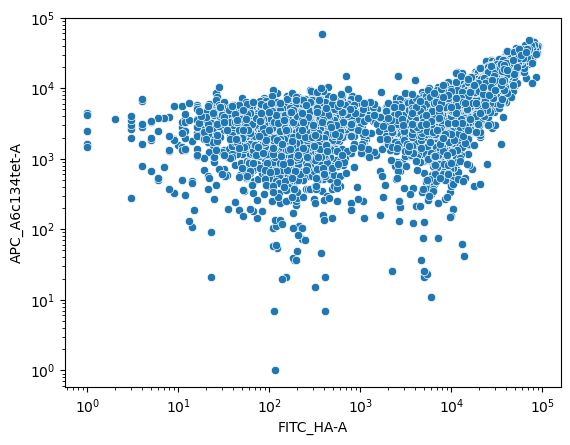

In [8]:
sns.scatterplot(data=data,x='FITC_HA-A',y='APC_A6c134tet-A')
plt.loglog()

In [9]:
def read_code(code):
    files = glob(f'{base_dir}export_{code}*_Single Cells.csv')
    assert len(files) == 1
    data = pd.read_csv(files[0])
    return data

2.992992992992993


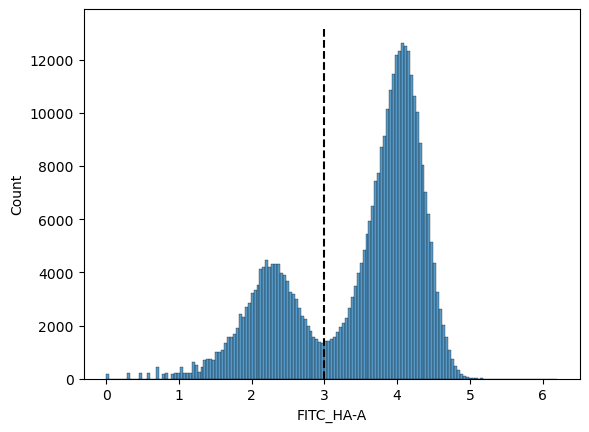

In [10]:
rows = {
    'A':'TCR (A6c134)',
    'B':'TCR (ctrl)',
    'C':'anti-A02',
    'D':'SA (ctrl)'
}

cols = {
    'hit6':[1,2,3],
    'CSM8':[7,8,9],
    'CSM8-L11':[4,5,6],
    'SCT':[10,11,12]
}

#get cutoff
expr = pd.concat([read_code(f'{row}{str(col).zfill(2)}')[['FITC_HA-A']] for row in rows for name in cols for col in cols[name]],axis=0)
expr = expr[expr['FITC_HA-A']>0]
kde = gaussian_kde(np.log10(expr.values.flatten()))
x_kde = np.linspace(2,4,1000)
y_kde = kde.pdf(x_kde)
cutoff = x_kde[y_kde==min(y_kde)][0]
print(cutoff)

sns.histplot(np.log10(expr['FITC_HA-A']))
plt.plot([cutoff]*2,plt.ylim(),'k--')

In [11]:
stain_name = {
    'A':'APC_A6c134tet-A',
    'B':'APC_S6Htet-A',
    'C':'APC_A2-A',
    'D':'APC_SA-A'
}
stain_cutoff = {}
for row in ['A','C']:
    tag_neg = []
    for name in cols:
        for col in cols[name]:
            code = f'{row}{str(col).zfill(2)}'
            data = read_code(code)
            tag_neg.append(data[np.log10(data['FITC_HA-A'])<=cutoff])
    tag_neg = pd.concat(tag_neg,axis=0)
    stain_cutoff[rows[row]] = np.quantile(tag_neg[stain_name[row]],0.99)
print(stain_cutoff)

{'TCR (A6c134)': 6969.800000000003, 'anti-A02': 3577.480000000003}


/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-pack

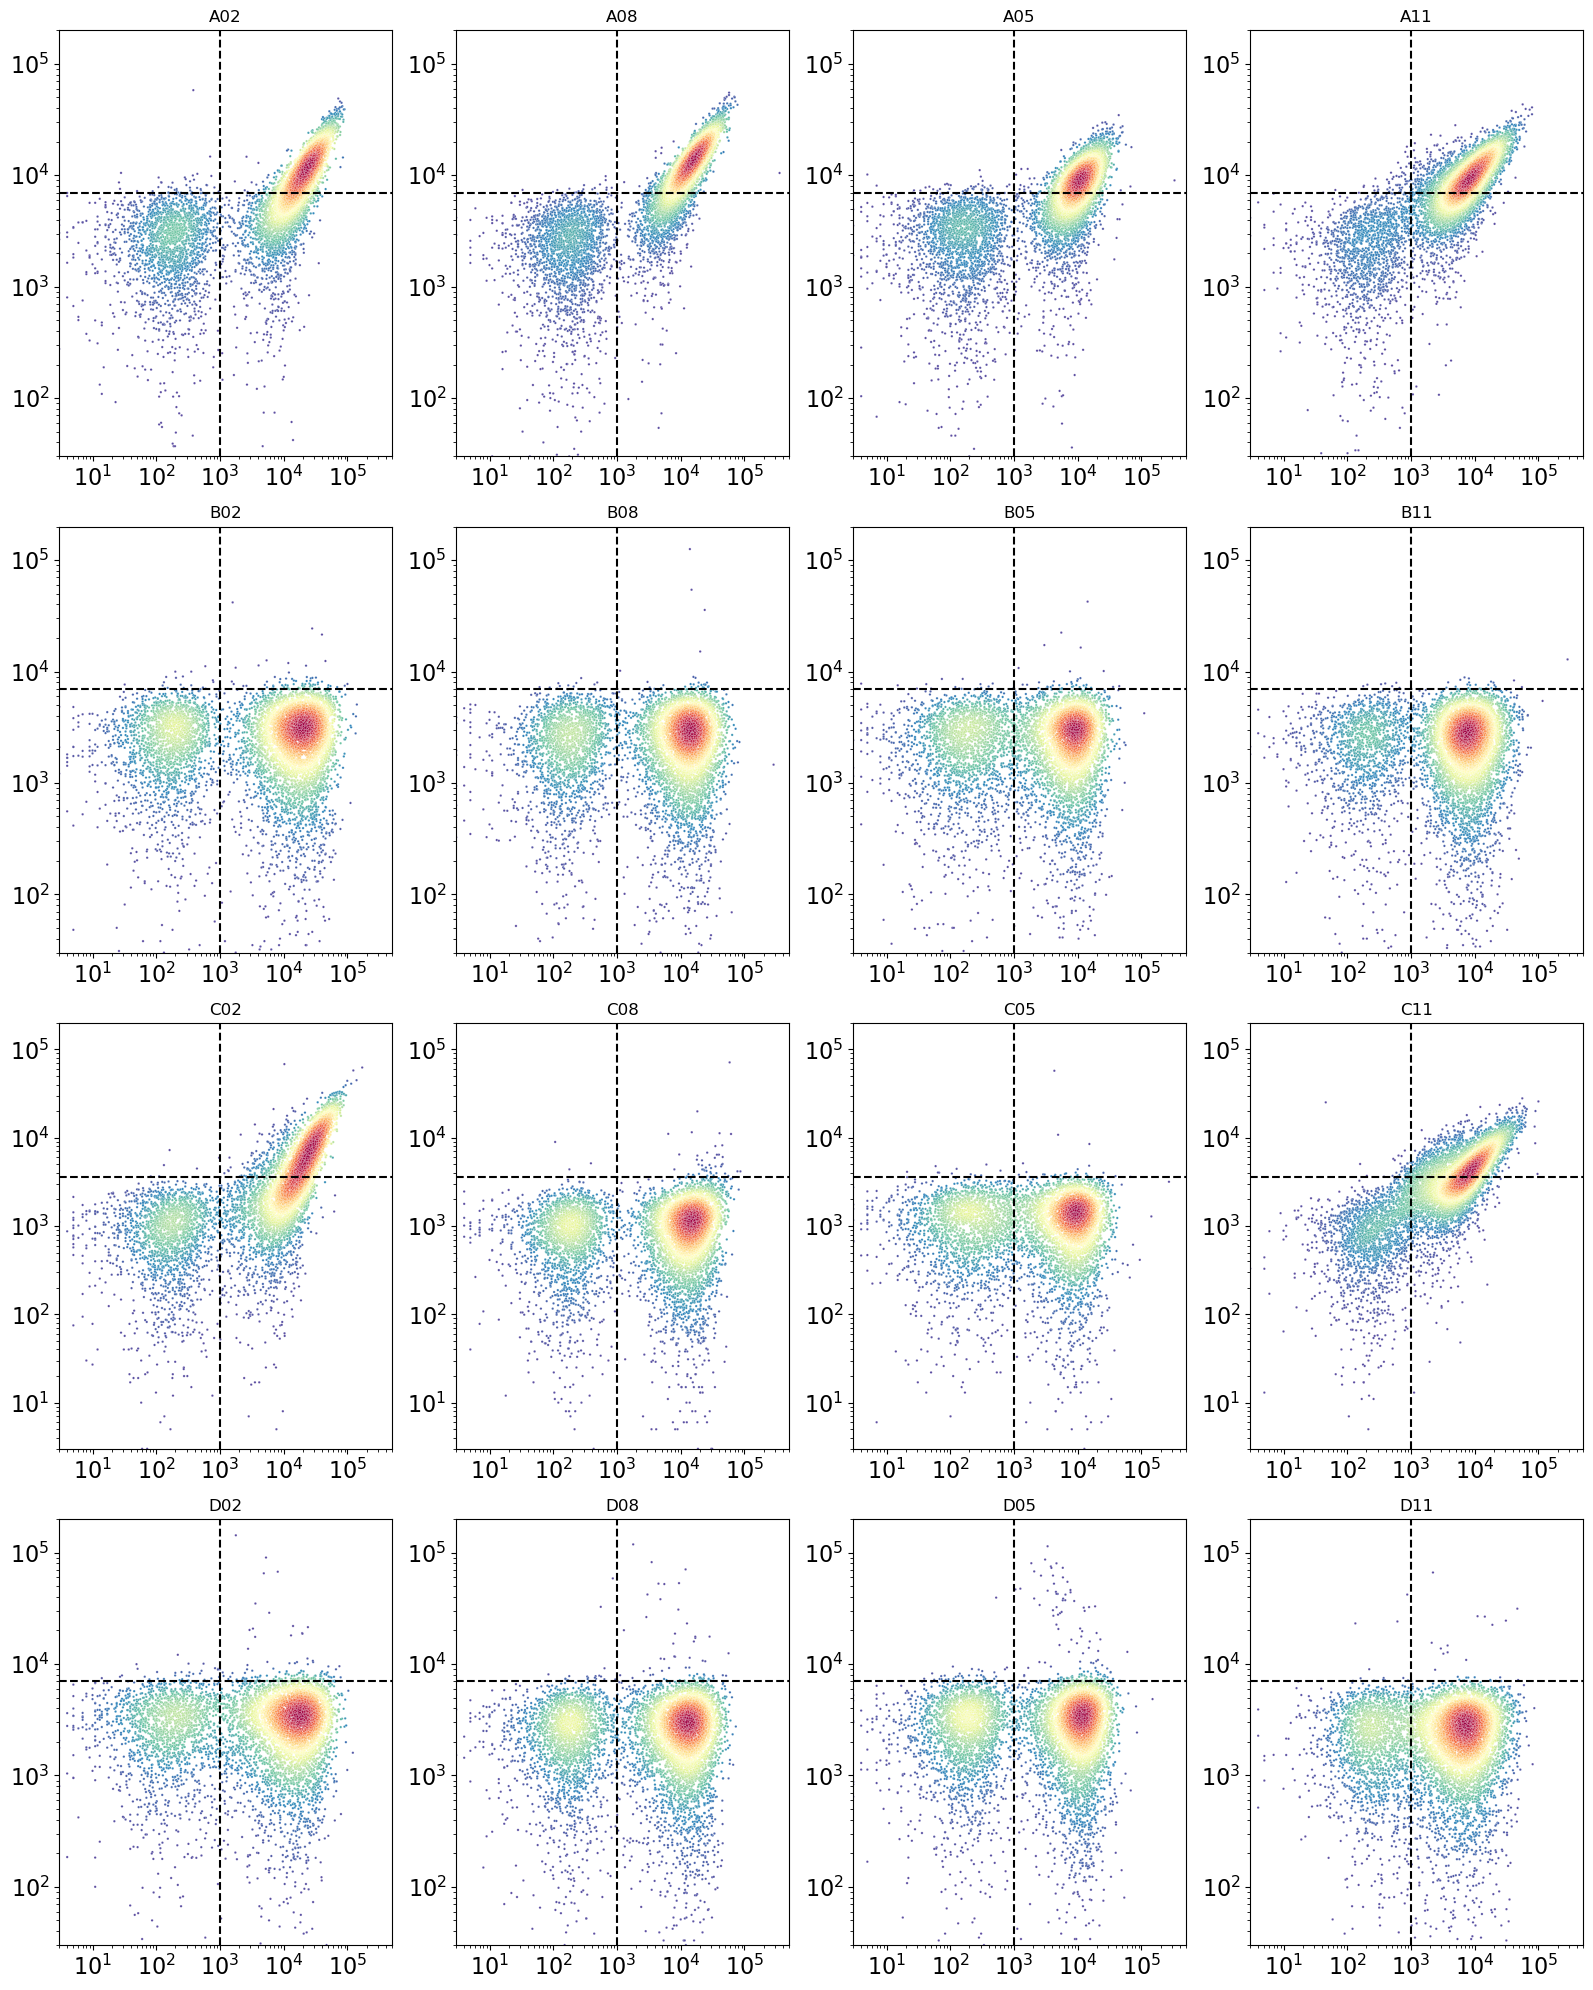

In [12]:
plt.figure(figsize=[20,20])
lims = {
    'TCR (A6c134)':[30,2e5],
    'anti-A02':[3,2e5]
}

cutoff_name = {
    'A':'TCR (A6c134)',
    'B':'TCR (A6c134)',
    'C':'anti-A02',
    'D':'TCR (A6c134)'
}
for r,row in enumerate(rows):
    for c,name in enumerate(cols):
        code = f'{row}{str(cols[name][1]).zfill(2)}'
        data = read_code(code)

        usable = data.loc[(data['FITC_HA-A']>0)&(data[stain_name[row]]>0),['FITC_HA-A',stain_name[row]]]
        kde = gaussian_kde(np.log10(usable.values.T))

        plt.subplot(4,5,c + 5*r + 1)
        sns.scatterplot(data=usable,
                        x='FITC_HA-A',
                        y=stain_name[row],
                        hue=kde.pdf(np.log10(usable.values.T)),
                        legend=None,
                        palette='Spectral_r',
                        s=3)

        plt.plot([3,5e5],[stain_cutoff[cutoff_name[row]]]*2,'k--')
        plt.plot([10**cutoff]*2,lims[cutoff_name[row]],'k--')

        # if s==0:
        plt.title(code)
        plt.xlim([3,5e5])
        plt.ylim(lims[cutoff_name[row]])
        plt.loglog()

        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # if s!=1:
        #     plt.xticks([])
        # if c!=0:
        #     plt.yticks([])
plt.tight_layout()

In [13]:
summary = []
for r,row in enumerate(rows):
    for c,name in enumerate(cols):
        for i,rep in enumerate(cols[name]):
            code = f'{row}{str(rep).zfill(2)}'
            data = read_code(code)
    
            tag_idx = data['FITC_HA-A']>10*cutoff
            frac_tag = np.mean(tag_idx)
            mean_tag = data.loc[tag_idx,'FITC_HA-A'].mean()/(10**cutoff)
    
            stain_idx = tag_idx & (data.loc[tag_idx,stain_name[row]]>stain_cutoff[cutoff_name[row]])
            frac_stain = np.sum(stain_idx)/np.sum(tag_idx)
            mean_stain = data.loc[stain_idx,stain_name[row]].mean()/stain_cutoff[cutoff_name[row]]
    
            summary.append([rows[row], name, i, frac_tag, mean_tag, frac_stain, mean_stain])
summary = pd.DataFrame(summary,columns=['stain', 'name', 'rep', 'frac_tag', 'mean_tag', 'frac_stain', 'mean_stain'])

summary

,stain,name,rep,frac_tag,mean_tag,frac_stain,mean_stain
0,TCR (A6c134),hit6,0,0.910561,13.849047,0.506862,2.230252
1,TCR (A6c134),hit6,1,0.936298,15.103031,0.424833,2.009384
2,TCR (A6c134),hit6,2,0.820260,12.731352,0.538718,2.331059
3,TCR (A6c134),CSM8,0,0.882011,9.677063,0.136730,1.267532
4,TCR (A6c134),CSM8,1,0.959523,10.883728,0.523917,2.181296
5,TCR (A6c134),CSM8,2,0.950083,9.574214,0.497317,1.929222
6,TCR (A6c134),CSM8-L11,0,0.933350,9.479686,0.499734,1.947706
7,TCR (A6c134),CSM8-L11,1,0.922525,7.979506,0.408891,1.574921
8,TCR (A6c134),CSM8-L11,2,0.965080,8.650573,0.509453,1.981654
9,TCR (A6c134),SCT,0,0.907442,6.981284,0.520947,1.635669


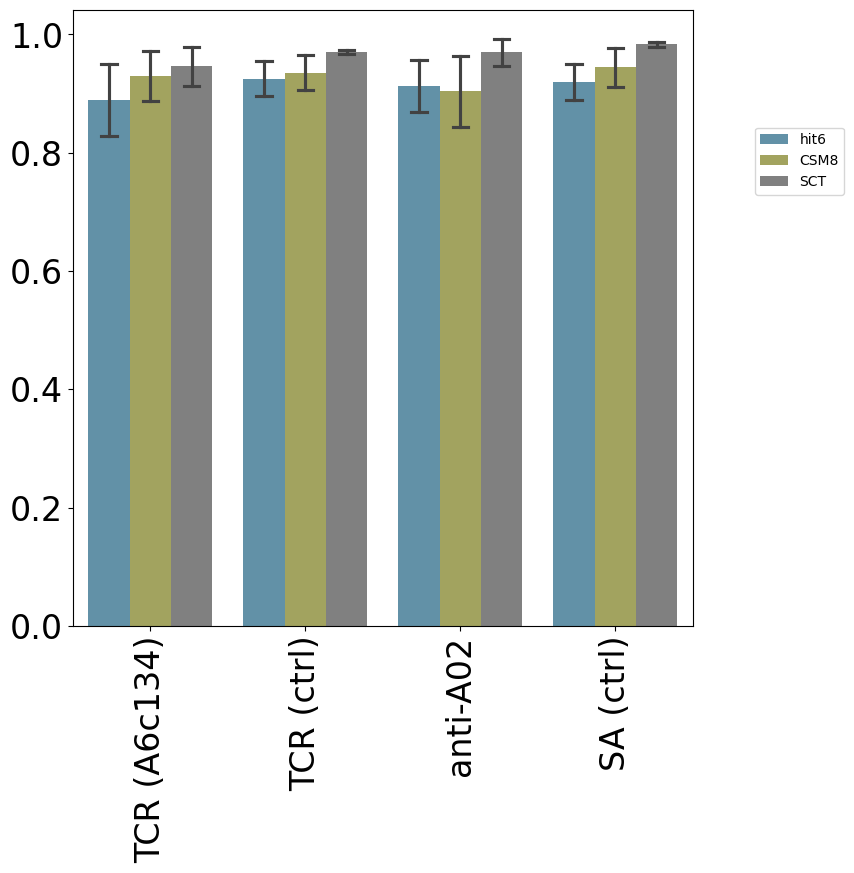

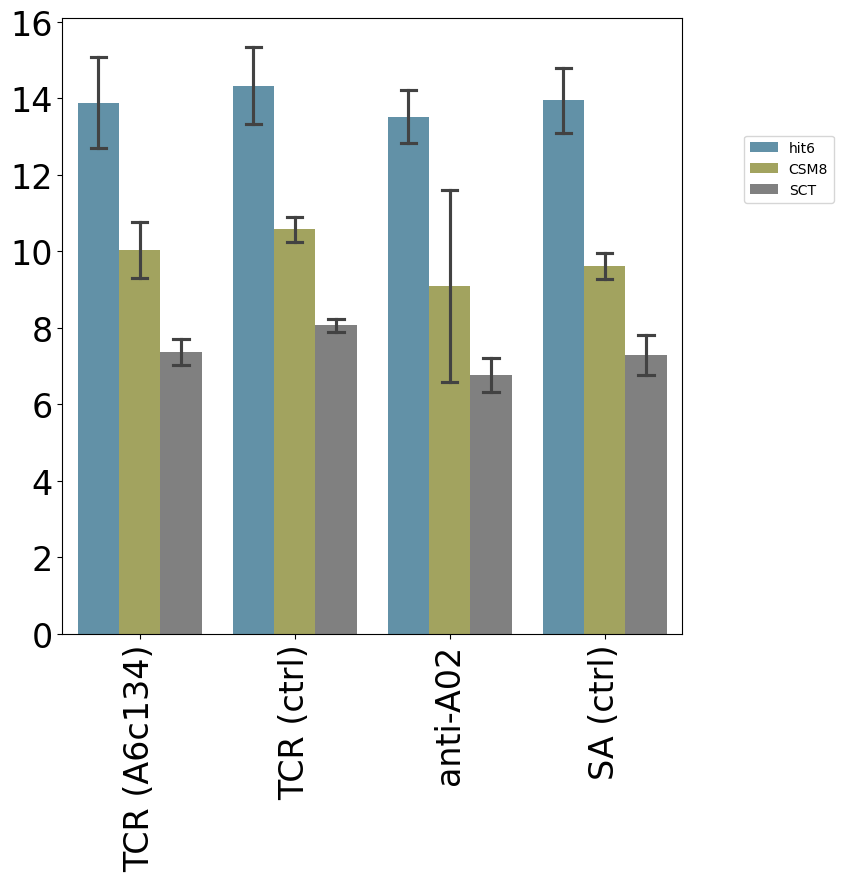

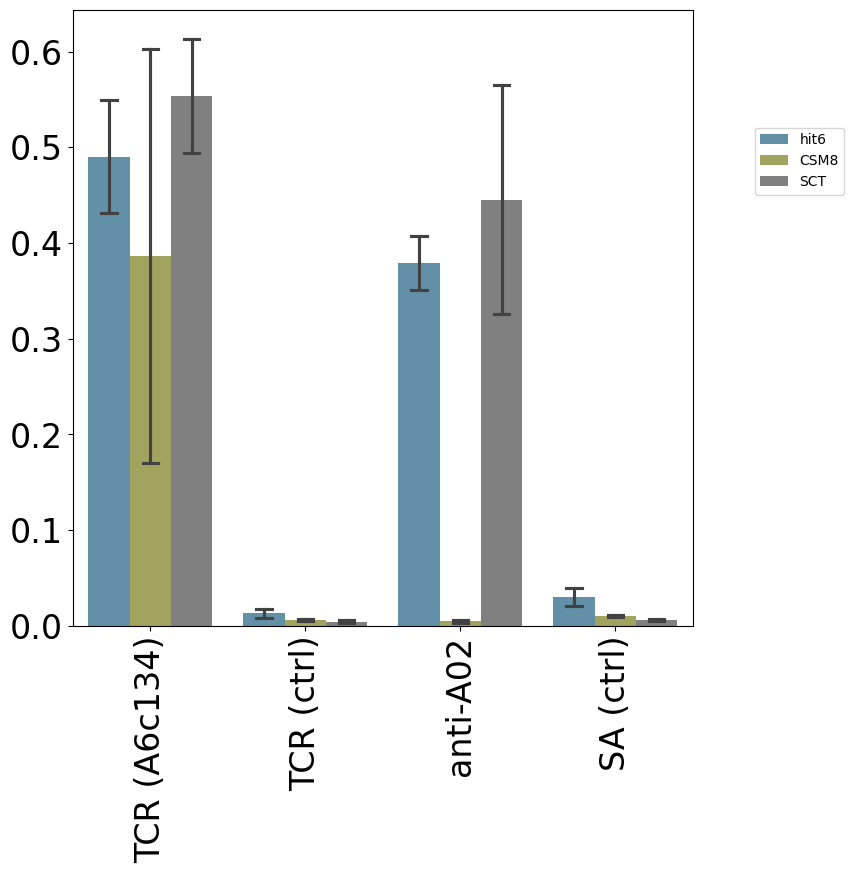

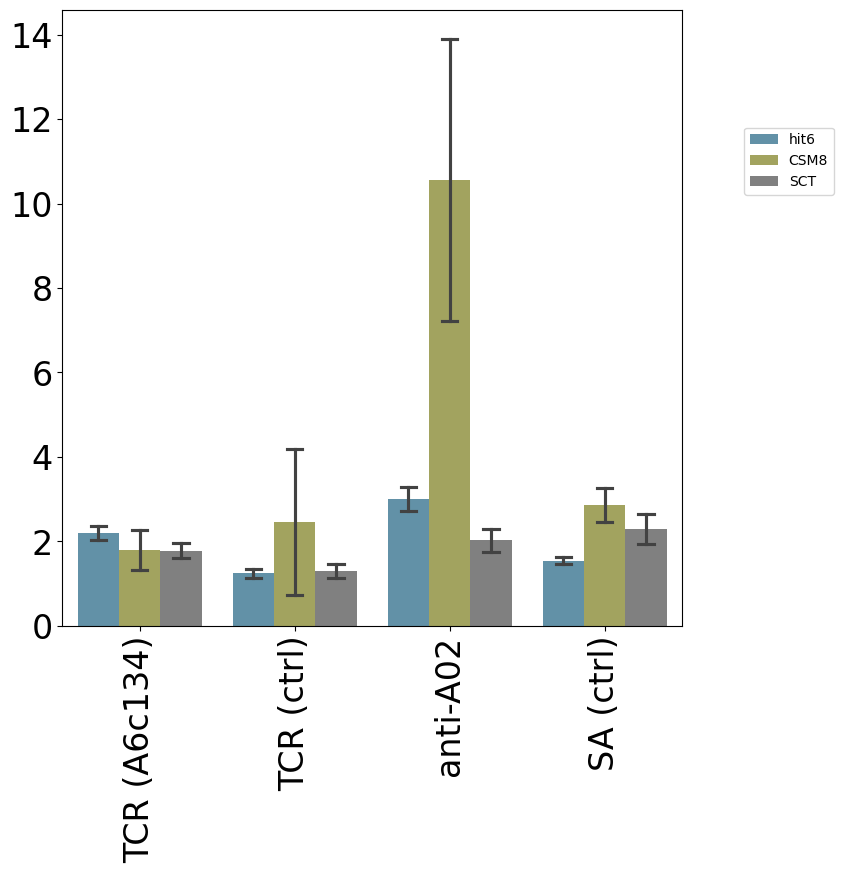

In [29]:
colors = {
    'hit6':'#5795B2',
    'CSM8':'#ADAE54',
    'CSM8-L11':'#48327F',
    'SCT':'gray'
}
alpha = [1,0.5]
for y in [col for col in summary.columns if '_' in col]:
    plt.figure(figsize=[8,8])

    sns.barplot(data=summary[summary['name']!='CSM8-L11'],x='stain',hue='name',y=y,palette=colors,
                errorbar=('sd',1),capsize=0.3)
    
    plt.xticks(fontsize=24,rotation=90)
    plt.yticks(fontsize=24)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc=[1.1,0.7])
    plt.savefig(f'yeast_display_{y}_barplot.png',dpi=300,bbox_inches='tight')